# Classification model evaluation

In [2]:
import os
main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(main_dir)

import pyvdirs.dirs as dirs
import sys
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

In [3]:
import torch
import torchvision as torchv
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pyvtorch.aux as vtaux
import timm
import PIL
import builtins
import pickle
from pyvtools.text import find_numbers, filter_by_string_must
from sklearn import metrics
from jeevan.wavemix.classification import WaveMix

import karras.dnnlib as dnnlib
from karras.training.encoders import PRETRAINED_HOME
import Images.calculate_metrics as calc
import Images.generate_images as gen
import Images.get_validation_metrics as valm
import ours.utils as utils

%load_ext autoreload
%autoreload 2

/home/valeria/anaconda3/envs/SCIDev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basics

### Load dataset

In [3]:
dataset_name = "tiny"

In [4]:
dataset_kwargs = calc.get_dataset_kwargs(dataset_name, image_path=None)
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs, random_seed=0)

In [5]:
dataset_obj.get_details(499)

{'raw_idx': 499,
 'xflip': False,
 'raw_label': 0,
 'name_label': 'n01443537',
 'words_label': 'Goldfish, carassius auratus'}

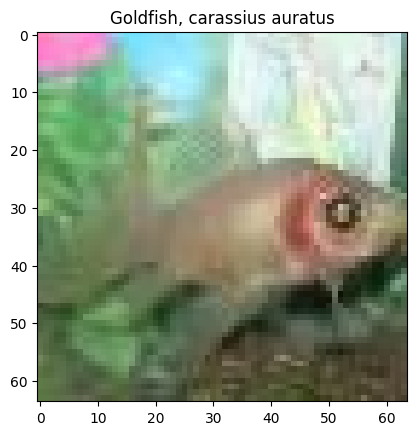

In [7]:
dataset_obj.visualize(0)

In [584]:
dataset_obj.get_name_from_label(0)

'n01443537'

In [8]:
dataset_obj.get_label_from_name("n01443537")

0

In [9]:
dataset_obj.get_label_from_name("n01774384")

8

In [ ]:
idx, img, lab = dataset_obj[8*500+432]
print(img.shape)
print(img.max())

torch.Size([3, 64, 64])
tensor(232.)


### Load dataset with the proper transformations instead

In [ ]:
dataset_name="tiny"
do_minus11_rescale=False
do_01_rescale=True
do_upsample=True
upsample_dim=384
do_normalize=True

dataset_obj = valm.load_dataset(dataset_name=dataset_name, 
                                do_minus11_rescale=do_minus11_rescale, do_01_rescale=do_01_rescale,
                                do_upsample=do_upsample, upsample_dim=upsample_dim,
                                do_normalize=do_normalize)

idx, img, lab = dataset_obj[8*500+432]
print(img.shape)
print(img.max())

torch.Size([3, 384, 384])
tensor(1.9420)


### Determine order discrepancy between Kaggle and Tiny ImageNet 

In [8]:
kaggle_order_filepath = os.path.join(dirs.DATA_HOME, "tiny_kaggle_labels.pkl")
with builtins.open(kaggle_order_filepath, "rb") as f:
    kaggle_order = pickle.load(f)

In [9]:
kaggle_order

{'n01774384': 0,
 'n04067472': 1,
 'n01984695': 2,
 'n03388043': 3,
 'n02769748': 4,
 'n09246464': 5,
 'n01855672': 6,
 'n06596364': 7,
 'n02815834': 8,
 'n03617480': 9,
 'n02892201': 10,
 'n01944390': 11,
 'n02395406': 12,
 'n03770439': 13,
 'n02279972': 14,
 'n02321529': 15,
 'n03902125': 16,
 'n02058221': 17,
 'n02988304': 18,
 'n02132136': 19,
 'n04259630': 20,
 'n03544143': 21,
 'n02002724': 22,
 'n02123394': 23,
 'n01443537': 24,
 'n02113799': 25,
 'n03584254': 26,
 'n07871810': 27,
 'n07768694': 28,
 'n02056570': 29,
 'n04399382': 30,
 'n04118538': 31,
 'n02236044': 32,
 'n03937543': 33,
 'n03250847': 34,
 'n01698640': 35,
 'n07873807': 36,
 'n02129165': 37,
 'n02837789': 38,
 'n04597913': 39,
 'n03977966': 40,
 'n01784675': 41,
 'n04532106': 42,
 'n02504458': 43,
 'n04507155': 44,
 'n01770393': 45,
 'n02802426': 46,
 'n03400231': 47,
 'n09193705': 48,
 'n04560804': 49,
 'n04417672': 50,
 'n03837869': 51,
 'n04149813': 52,
 'n03404251': 53,
 'n04487081': 54,
 'n02364673': 55,
 '

In [ ]:
from_kaggle_indices = []
extra_classes_in_kaggle = []
for k in kaggle_order.keys():
    try:
        from_kaggle_indices.append( dataset_obj.get_label_from_name(k) )
    except:
        extra_classes_in_kaggle.append(k)
        from_kaggle_indices.append( None  )
if len(extra_classes_in_kaggle)!=0:
    print(f"Kaggle has {len(extra_classes_in_kaggle)} classes not present in HuggingFace")
    for k in extra_classes_in_kaggle:
        print(">", dataset_obj.get_words_from_name(k))

In [42]:
to_kaggle_indices = []
extra_classes_in_tiny = []
for lab in range(200):
    tiny_name = dataset_obj.get_name_from_label(lab)
    if tiny_name in kaggle_order.keys():
        to_kaggle_indices.append( kaggle_order[tiny_name] )
    else:
        words = dataset_obj.get_words_from_label(lab)
        names = dataset_obj.get_all_names_from_words_label(words)
        found = False
        for n in names:
            if n in kaggle_order.keys():
                to_kaggle_indices.append( kaggle_order[n] )
                found = True
                break
        if not found:
            extra_classes_in_tiny.append( tiny_name )
            to_kaggle_indices.append( None )
if len(extra_classes_in_tiny)!=0:
    print(f"HuggingFace has {len(extra_classes_in_tiny)} classes not present in Kaggle")
    for k in extra_classes_in_tiny:
        print(">", dataset_obj.get_words_from_name(k))

In [39]:
dataset_obj.get_words_from_label(8)

'Black widow, latrodectus mactans'

In [43]:
dataset_obj.get_words_from_label(from_kaggle_indices[0])

'Black widow, latrodectus mactans'

In [45]:
from_kaggle_indices[ 0 ]

8

In [57]:
from_kaggle_indices.index(0)

24

In [60]:
dataset_obj.get_words_from_name( list(kaggle_order.keys())[24] )

'Goldfish, carassius auratus'

### Save files to fix order discrepancy

In [ ]:
new_filepath = os.path.join(dirs.DATA_HOME, "tiny_kaggle_to_huggingface.txt")
np.savetxt(new_filepath, from_kaggle_indices, fmt="%.0f")

In [ ]:
new_filepath = os.path.join(dirs.DATA_HOME, "tiny_huggingface_to_kaggle.txt")
np.savetxt(new_filepath, to_kaggle_indices, fmt="%.0f")

### Load files to fix order discrepancy

In [6]:
reorder_filepath = os.path.join(dirs.DATA_HOME, "tiny_kaggle_to_huggingface.txt")
labels_translator = valm.load_labels_translator(reorder_filepath)

In [7]:
labels_translator.from_aux_to_main(0)

8

In [8]:
labels_translator.to_aux_from_main(8)

0

In [9]:
dataset_obj.get_words_from_label(8)

'Black widow, latrodectus mactans'

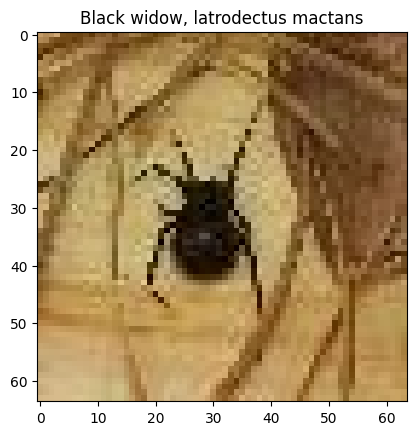

In [10]:
dataset_obj.visualize(8*500+432)

## WaveMix-192/16 (level 3) $\rightarrow$ 77.47%

### Load model

In [22]:
model = valm.load_wavemix_model(verbose=True)

> Have the model parameters changed? True
> Which fraction of them changed? 100.00%


In [23]:
model

WaveMix(
  (layers): ModuleList(
    (0-15): 16 x Level3Waveblock(
      (feedforward1): Sequential(
        (0): Conv2d(288, 384, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.5, inplace=False)
        (3): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1))
        (4): ConvTranspose2d(192, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (feedforward2): Sequential(
        (0): Conv2d(288, 384, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.5, inplace=False)
        (3): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1))
        (4): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (feedforward3): Sequential(
        (0): Conv2d(192, 38

### Get classification metrics for the dataset

In [26]:
n_samples = 10
batch_size = 1
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, 
                                          do_upsample=True, upsample_dim=128,
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "wavemix"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:01<00:00,  7.03it/s]

Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [25]:
confusion_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=uint32)

In [27]:
n_samples = 4000
batch_size = 100
save_period = 5
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False,
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "wavemix"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 40/40 [02:22<00:00,  3.55s/it]

Top-1 Accuracy 0.00025
Top-5 Accuracy 0.005


In [28]:
confusion_matrix[0].argmax()

np.int64(22)

In [29]:
confusion_matrix[1].argmax()

np.int64(29)

In [30]:
confusion_matrix[2].argmax()

np.int64(29)

In [31]:
confusion_matrix[4].argmax()

np.int64(29)

In [32]:
confusion_matrix[:4]

array([[  0,   5,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
         12,   0,   1,   0,   0,   3,   0,   2,   3, 101,   0,   1,  30,
          0,   0,   0,  10,  29,   5,   0,   2,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
          0,   0,   0,   0,   2,   0,   0,   0,   0,   1,  89,   5,   0,
          3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   1,   0,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   2,   4,   0,
          1,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  18,   0,   1,   5,   1,   0,   1,
          1,   0,   0,   0,   0,   6,  13,   1,  13,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   1,   1,   0,  60,   0,   0,   4,   0

## ResNet-101 $\rightarrow$ Accuracy 84.39%

### Load model

In [4]:
model = valm.load_resnet_101_model(verbose=True)
model.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1,1))
model.eval()

Loading ResNet-101 for TinyImageNet
> Have the model parameters changed? True
> Which fraction of them changed? 100.00%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[ 1.6219e-02, -8.1124e-03, -2.0647e-02,  ..., -1.6463e-02,
           -1.4927e-04,  1.1889e-02],
          [-1.5075e-02, -9.0934e-03, -2.7991e-02,  ..., -9.1025e-02,
           -7.7257e-02, -3.9201e-02],
          [-3.6561e-03,  1.9346e-02,  4.3625e-02,  ...,  3.2203e-02,
            1.5482e-02,  3.1234e-02],
          ...,
          [-4.8363e-02, -1.3125e-01, -2.9607e-01,  ..., -3.6000e-01,
           -1.2723e-01,  3.4665e-02],
          [-1.1324e-03,  1.6052e-02,  7.0292e-03,  ..., -1.5757e-01,
           -1.8505e-01, -1.1095e-01],
          [-3.9803e-02, -1.2397e-02,  5.3014e-02,  ...,  1.6523e-01,
            9.6289e-02, -2.5995e-02]],

         [[ 1.1675e-02, -3.2693e-03, -9.8972e-03,  ..., -9.3783e-03,
            2.2246e-02,  2.7261e-02],
          [-1.1643e-02,  3.3755e-03, -1.5723e-02,  ..., -8.1126e-02,
           -5.6523e-02, -1.5057e-02],
          [-4.6527e-03,  2.8838e-02,  7.2211e-02,  ...,  9.0631e-02,
            5.6185e-02,  4.1675e-02]

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Get classification metrics for the dataset

In [6]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False,
                                          do_01_rescale=True, do_normalize=True)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:01<00:00,  9.68it/s]

Top-1 Accuracy 0.21
Top-5 Accuracy 0.41


In [69]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False,
                                          do_normalize=True)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

transform Compose(
    From8bitTo01()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Top-1 Accuracy 0.21
Top-5 Accuracy 0.41


In [70]:
n_samples = 2000
batch_size = 100
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False,
                                          do_normalize=True)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

transform Compose(
    From8bitTo01()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Top-1 Accuracy 0.1065
Top-5 Accuracy 0.267


In [47]:
confusion_matrix[0]

array([105,   0,   1,   0,   0,   1,   0,   0,   1,   0,   1,   0,   0,
         6,   0,   2,   0,   3,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  12,   2,   1,
         0,   1,   4,   1,   2,  39,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   1,   0,   1,   0,   0,   0,
         0,   0,   0,   4,   2,   0,   0,   0,   3,   0,   0,   1,   0,
         1,   0,   2,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,
         0,   0,   0,   0,   1,   0,   1,   2,   1,   0,  23,   0,   0,
         1,   0,   0,   0,   0,   0,   0,   0,   2,  13,   3,  14,   0,
         0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,
        10,   1,   2,   0,   0,   1,   0,   2,   3,   0,   3,   0,   0,
         1,   1,   0,   1,   0,   0,   0,   3,  10,  17,   0,   1,   2,
         2,   0,   0,   6,   1,   0,   0,  18,   0,   0,   0,   0,  20,
         0,   0,   0,   0,   0,   9,   2,  25,   3,   0,   0,   

In [ ]:
dataset_obj.get_words_from_label(186)

'Pole'

In [51]:
img = dataset_obj[500*186][1]

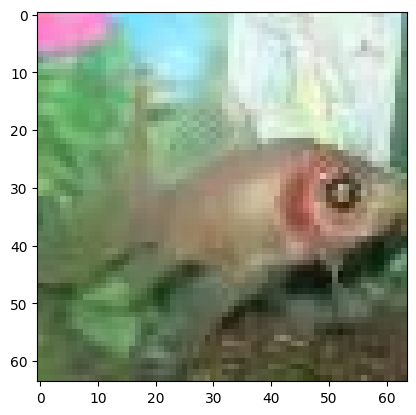

In [ ]:
idx = 0
# idx = 500*186

dataset_obj.visualize(idx)

In [36]:
confusion_matrix[1]

array([  0,  45,   1,   0,   1,  15,   0,   0,   6,   0,  11,   0,   0,
         0,   6,   1,   0,   7,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0,
         2,  13,   2,   2,   6, 111,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
         1,   0,   0,   0,   0,   0,   0,   0,   2,   1,   2,   0,   0,
         2,   0,   1,   0,   0,   0,   0,   0,   0,   4,   4,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
         0,   0,   1,   0,   2,   0,   1,   0,   0,  43,   0,   0,   0,
         1,   0,   1,   0,   0,   6,   0,   0,   1,   1,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   1,   0,   1,   0,   0,   0,   3,  34, 117,   0,   1,   1,
         2,   2,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,  19,   0,   0,   0,   

In [11]:
confusion_matrix[0].argmax()

np.int64(193)

In [10]:
confusion_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
       0, 0], dtype=uint32)

In [11]:
n_samples = 10
batch_size = 1
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 200]) tensor([193]) tensor([[163, 140, 145, 159, 193]])
Inconsistency found: n_seen is 1, but n_samples is 10
Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [12]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:00<00:00, 11.38it/s]

Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [12]:
n_samples = 4000
batch_size = 100
save_period = 5
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 40/40 [00:51<00:00,  1.28s/it]

Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


### Load results

In [35]:
confusion_matrix, top_5_correct = valm.load_last_classification_metrics("ResNet")

In [37]:
confusion_matrix[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   5,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   1,   0,   0,   0,  35,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [52]:
confusion_matrix[0].argmax()

np.int64(193)

In [43]:
confusion_matrix[1].argmax()

np.int64(193)

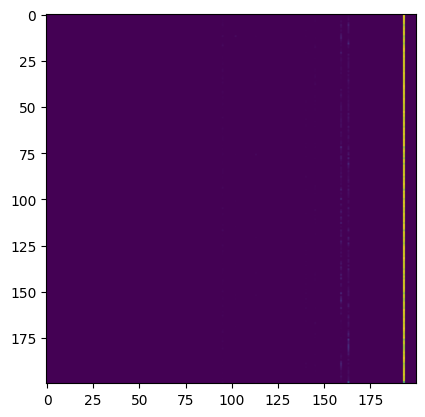

In [53]:
plt.imshow(confusion_matrix/confusion_matrix.max())

## Swin-L $\rightarrow$ Accuracy 91.35%

Data preparation
- Convert from uint8 ByteTensor to float32 tensor
- Divide by 255 $\Rightarrow$ Convert from [0,255] to [0,1] range
- Normalize using `transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`


### Load model

In [56]:
model = valm.load_swin_l_model(verbose=True)

Loading Swin-L for TinyImageNet


> Have the model parameters changed? True
> Which fraction of them changed? 100.00%


In [57]:
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
           

In [58]:
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[ 0.0605,  0.0534, -0.0171, -0.0432],
          [ 0.0720,  0.0877,  0.0082, -0.0032],
          [-0.0045,  0.0071, -0.0232, -0.0093],
          [-0.0529, -0.0833, -0.0649,  0.0114]],

         [[ 0.0130,  0.0264, -0.0618, -0.0808],
          [ 0.0709,  0.0898,  0.0157,  0.0061],
          [-0.0071,  0.0031, -0.0099,  0.0097],
          [-0.0631, -0.0589, -0.0319,  0.0541]],

         [[-0.0529, -0.0189, -0.0611, -0.0515],
          [ 0.0104,  0.0500,  0.0216,  0.0263],
          [-0.0215, -0.0042,  0.0024,  0.0452],
          [-0.0486, -0.0345,  0.0170,  0.1134]]],


        [[[-0.0458,  0.0159,  0.0492,  0.0623],
          [-0.0489,  0.1477, -0.0118, -0.1687],
          [-0.0515, -0.0985,  0.1056, -0.0493],
          [ 0.0473,  0.1081, -0.0831,  0.0070]],

         [[-0.0525, -0.0673, -0.0062,  0.1234],
          [ 0.1467,  0.0696, -0.1720, -0.0963],
          [-0.0745,  0.0414,  0.0792,  0.0950],
          [ 0.0430, -0.1861,  0.0911, -0.0761]],

      

### Get classification metrics for the dataset

In [29]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          do_upsample=True, upsample_dim=384, 
                                          do_normalize=True, do_01_rescale=True,
                                          save_period=save_period, verbose=True, 
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "swin"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 10%|█         | 1/10 [00:03<00:31,  3.51s/it]

tensor([[ 10,  40,  15,  23,   0],
        [ 78,  34, 174,  13,   0],
        [140,  86, 152,  65,   0],
        [ 67,  80,  19, 196,   0],
        [ 47,  24,  31,  26,   0],
        [ 43, 184, 186, 187,   0],
        [135,  61,  93, 176,   0],
        [141, 130,  36, 110,   0],
        [ 13, 152, 197, 101,   0],
        [130,  86,  13,  83,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 20%|██        | 2/10 [00:06<00:27,  3.46s/it]

tensor([[152, 187, 196,  13,   0],
        [179,  38, 180,  13,   0],
        [152, 140, 170,  92,   0],
        [174,  87, 104, 177,   0],
        [187,  67, 188,  79,   0],
        [152,   2,  13,   4,   0],
        [ 38,  43, 152,  45,   0],
        [171,  13, 157, 152,   0],
        [ 24, 192, 196,  13,   0],
        [159,  79, 130, 186,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 30%|███       | 3/10 [00:10<00:23,  3.42s/it]

tensor([[ 79, 101,  13, 140,   0],
        [184, 101,  37,  41,   0],
        [188, 110, 130,  59,   0],
        [175, 188, 186, 193,   0],
        [186, 120, 180,  13,   0],
        [192, 191, 179, 177,   0],
        [ 18, 152,  13, 196,   0],
        [197, 180, 186, 152,   0],
        [104,   4,   5,  82,   0],
        [ 13, 185,  29,  47,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 40%|████      | 4/10 [00:13<00:20,  3.37s/it]

tensor([[186, 185, 189, 184,   0],
        [163,  38,  29, 152,   0],
        [174,  46,  43,  13,   0],
        [102,  13,  83, 152,   0],
        [117,  72, 109, 172,   0],
        [120,  13, 152,   0, 196],
        [119,  18, 180, 139,   0],
        [ 55,  17,  19,  13,   0],
        [157,  13, 152,  19,   0],
        [ 41,   0,  27, 114, 197]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 50%|█████     | 5/10 [00:16<00:16,  3.33s/it]

tensor([[ 41,  13, 196,  17,   0],
        [113,  92,  13,  83,   0],
        [176,   1,   9, 199,   0],
        [147,  63, 140,  89,   0],
        [191,  19, 143, 178,   0],
        [175, 187, 186, 188,   0],
        [189, 123, 138,  13,   0],
        [ 67,  62,  36,  41,   0],
        [ 13, 156,  83, 152,   0],
        [108, 152, 170,  92,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 60%|██████    | 6/10 [00:20<00:13,  3.32s/it]

tensor([[ 41, 152,  92, 159,   0],
        [ 36, 186, 199, 185,   0],
        [ 92, 170,  17, 196,   0],
        [ 42,  78,  36, 152,   0],
        [ 83, 188, 130,  93,   0],
        [184, 178,  43,  13,   0],
        [ 13,  92, 152, 184,   0],
        [ 83, 180,  92,  24,   0],
        [ 24, 172, 130,  13,   0],
        [197,  13, 196,  23,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 70%|███████   | 7/10 [00:23<00:10,  3.36s/it]

tensor([[ 13, 152,  67,  41,   0],
        [152,  92, 171, 196,   0],
        [163, 152,  45,  13,   0],
        [ 13, 157, 152, 170,   0],
        [ 80,  89, 155, 141,   0],
        [185,  13,  16,  15,   0],
        [163, 196,  43,  13,   0],
        [ 83,  13, 185, 163,   0],
        [  9,  23,   4,  19,   0],
        [135, 160,  72, 172,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 80%|████████  | 8/10 [00:27<00:06,  3.38s/it]

tensor([[177, 179,  13,  17,   0],
        [ 23,  16, 152, 196,   0],
        [  2,   7,  11,   4,   0],
        [161,  38,  16,  13,   0],
        [ 17,  16, 152,  13,   0],
        [ 92,  41,  46,  13,   0],
        [174,  87, 153,  99,   0],
        [ 83,  92, 152,  13,   0],
        [ 16,  46,  19,  17,   0],
        [140, 138,  67,  56,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


 90%|█████████ | 9/10 [00:30<00:03,  3.39s/it]

tensor([[171,  43, 180,  60,   0],
        [188, 178, 192, 181,   0],
        [156, 171, 196,  13,   0],
        [ 87, 156, 130, 174,   0],
        [ 39,  40, 188,  42,   0],
        [172, 130, 123,  72,   0],
        [  2,  15,   3,   4,   0],
        [ 79,  13, 130, 186,   0],
        [189,  83, 163,  13,   0],
        [ 44,  43,  38,  45,   0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]

tensor([[ 46,  41,  36,  25,   0],
        [186,  40,  88,  79,   0],
        [152,  46,  17,  10,   0],
        [ 13,  87, 160, 174,   0],
        [152,  37, 184, 187,   0],
        [ 71,  56,  31,  34,   0],
        [ 20,   4,  13,  23,   0],
        [190,  13,  72, 172,   0],
        [102, 101, 176,  43,   0],
        [184,  79, 130, 186,   0]])
Top-1 Accuracy 0.98
Top-5 Accuracy 1.0


In [31]:
confusion_matrix[0]

array([98,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0], dtype=uint32)

In [67]:
n_samples = 500
batch_size = 50
save_period = 1
results = valm.get_classification_metrics(model, "tiny", 
                                          n_samples=n_samples, batch_size=batch_size,
                                          do_upsample=True, upsample_dim=384, do_normalize=True,
                                          start_idx=11*500,
                                          save_period=save_period, verbose=True, 
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "swin"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

 10%|█         | 1/10 [00:21<03:15, 21.71s/it]

labels tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
fixed predicted_labels tensor([ 13,  35, 157,  13, 185, 196,  12,  13, 196,  13, 196, 141,  72,   5,
        157,  12,  17, 128, 127,  72, 157,  35,  13,  12,  12, 196, 196, 165,
         81, 194, 157,  12,  81,   6, 150,  35,   0,   7, 196, 115,  35, 196,
        127, 194,  72, 196,  18, 196,  12,  13])
fixed top_5_labels tensor([[150,  10, 196,   6,  13],
        [ 78,  37, 112, 157,  35],
        [ 78,  13, 140,  35, 157],
        [ 72,  78,  12, 196,  13],
        [ 61, 196, 161,  72, 185],
        [ 12,  36,   7,  78, 196],
        [  4,  72,  13, 141,  12],
        [ 12, 168, 157, 175,  13],
        [116,  35,  12,   7, 196],
        [ 35, 151,  37,  17,  13],
        [197,  35, 194,  72, 196],
        [ 35, 133,  12, 196, 141],
        [130,  78,  63,

 20%|██        | 2/10 [00:42<02:51, 21.46s/it]

labels tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
fixed predicted_labels tensor([ 12, 141, 150,  38,  13,   7, 196,  35,  18,  13, 157,  13,  12,   0,
         12,   0, 185,  24,  36,  13, 105, 157, 196, 196, 196,  12,  12,  35,
         83, 196, 121,  13,  78,  24,  13, 140, 105,  72,  13,  12,  35,  12,
        141, 141,  34,  12,  58,  78,  35, 127])
fixed top_5_labels tensor([[ 94,  13,  92, 141,  12],
        [ 35, 124,   6,  72, 141],
        [196, 133,  98,  12, 150],
        [ 18,  72, 141,  34,  38],
        [ 12,   6,  78,  72,  13],
        [196,  78,  72,  13,   7],
        [ 81,  58,  35, 194, 196],
        [ 17,  13, 185,  78,  35],
        [138,  12, 116, 196,  18],
        [ 72,   6,  78, 138,  13],
        [195,  40, 165, 132, 157],
        [ 12, 157,  78,   6,  13],
        [145, 105,   7,

 30%|███       | 3/10 [01:04<02:29, 21.41s/it]

labels tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
fixed predicted_labels tensor([124, 177, 157,  35, 138, 127,   7,  12, 141, 157,   7, 157, 141,   0,
        196,  40, 197, 194,  60, 115, 196, 127,  92, 141, 104,  81,  12, 164,
        139, 185,  72,  35, 149,  12, 138, 196,  13,  78, 165,  78,  12,  35,
         35,  13, 104,  78, 196,  12, 141,  58])
fixed top_5_labels tensor([[161,   6,  58, 196, 124],
        [196, 141,  13,  12, 177],
        [194,  38,  35,  12, 157],
        [131, 163, 171, 198,  35],
        [ 10,  12, 157,  13, 138],
        [140,  66, 133, 105, 127],
        [ 38,  18,  72, 196,   7],
        [196,  18,  13,   7,  12],
        [ 35,  51,  72, 124, 141],
        [ 38, 194, 196,  92, 157],
        [157,  23,  68,  12,   7],
        [ 13,  38,   0,  12, 157],
        [197, 196, 105,

 40%|████      | 4/10 [01:25<02:07, 21.32s/it]

labels tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
fixed predicted_labels tensor([194, 124,  12, 196,  12,  10,   7, 196,  72,  12,  35, 141,  83,  47,
         18,   7,  36,  81,  12,  72,  72,  35,  17, 124, 141,  18,  13,  18,
        196,  35,  13,  13, 127, 196, 196,  12, 196, 196,  13,  35, 196,  78,
        157, 115, 196, 157,  13,  35, 196,  78])
fixed top_5_labels tensor([[105,  78, 197, 122, 194],
        [ 78, 185,  72, 131, 124],
        [ 13, 141, 196,  78,  12],
        [105,  72,  78,  92, 196],
        [  7, 141, 196,  13,  12],
        [ 78,   6,   7,  12,  10],
        [ 10,   6,  36,  12,   7],
        [ 18,  12, 116,  72, 196],
        [  4, 141,  78,  35,  72],
        [157, 196,  78, 105,  12],
        [157, 185,  37,  78,  35],
        [ 47, 157,  12,  38, 141],
        [ 92, 162,  65,

 40%|████      | 4/10 [01:43<02:35, 25.86s/it]


KeyboardInterrupt: 

#### Old (no normalization nor 0,1 transformation)

In [ ]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          do_upsample=True, upsample_dim=384,
                                          save_period=save_period, verbose=True, 
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "swin"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:38<00:00,  3.86s/it]

Top-1 Accuracy 0.4
Top-5 Accuracy 0.77


### Load results

In [7]:
confusion_matrix, top_5_correct = valm.load_last_classification_metrics("Swin")

In [38]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

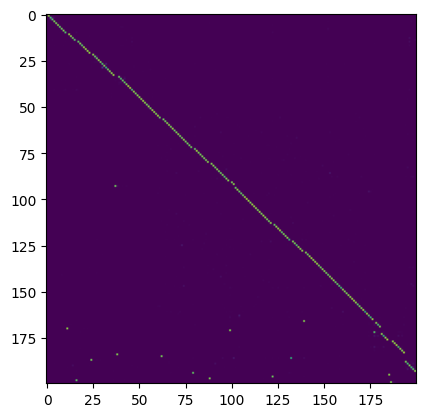

In [8]:
plt.imshow(confusion_matrix/confusion_matrix.max())

### Fix discrepancy in class order

#### Determine discrepancy order

$\rightarrow$ For each HuggingFace's class, what classifier class corresponds

In [ ]:
confusion_matrix, top_5_correct = valm.load_last_classification_metrics("Swin")

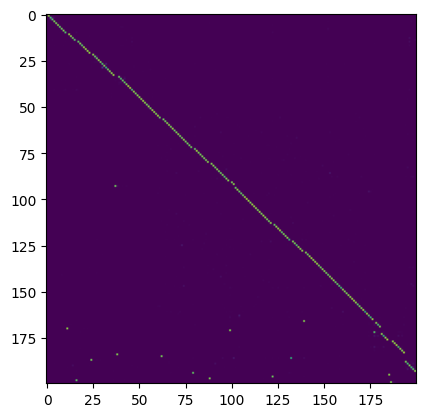

In [ ]:
plt.imshow(confusion_matrix/confusion_matrix.max())

In [63]:
predicted_indices = []
for i, counts in enumerate(confusion_matrix):
    predicted_indices.append( int(counts.argmax()) )
predicted_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 100,
 101,
 37,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 139,
 178,
 179,
 180,
 11,
 99,
 177,
 181,
 182,
 183,
 184,
 187,
 188,
 189,
 190,
 191,
 192,
 193,


In [46]:
for i in range(200):
    if i not in predicted_indices: print(f"Missing {i}")

In [64]:
np.savetxt(os.path.join(dirs.DATA_HOME, "tiny_swin_to_huggingface.txt"), predicted_indices, fmt="%.0f")

In [ ]:
# np.savetxt(os.path.join(dirs.DATA_HOME, "tiny_huggingface_to_swin.txt"), predicted_indices, fmt="%.0f")

#### Load classifier's order

In [4]:
reorder_filepath = os.path.join(dirs.DATA_HOME, "tiny_swin_to_huggingface.txt")
labels_translator = valm.load_labels_translator(reorder_filepath)

In [5]:
labels_translator.from_aux_to_main(11)

12

In [6]:
labels_translator.indices_from_aux

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 100,
 101,
 37,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 139,
 178,
 179,
 180,
 11,
 99,
 177,
 181,
 182,
 183,
 184,
 187,
 188,
 189,
 190,
 191,
 192,
 193,


#### Use the order to fix the discrepancy

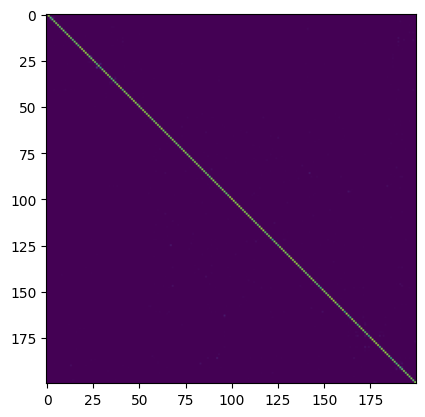

In [10]:
new_confusion_matrix = confusion_matrix[:, labels_translator.indices_from_aux]
plt.imshow(new_confusion_matrix/new_confusion_matrix.max())

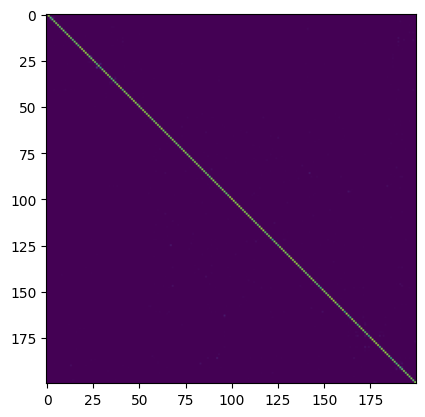

In [ ]:
new_confusion_matrix = confusion_matrix[:, predicted_indices]
plt.imshow(new_confusion_matrix/new_confusion_matrix.max())

In [11]:
top_1_accuracy = float( new_confusion_matrix.diagonal().sum() /  100096)
top_1_accuracy

0.9204563618925832

## Generic

In [17]:
confusion_matrix, top_5_correct = valm.load_last_classification_metrics(
    "Swin", "generated",  os.path.join(dirs.MODELS_HOME, "Images/04_Tiny_LR/Baseline/04/gen_images/network-snapshot-0039500-0.100"))

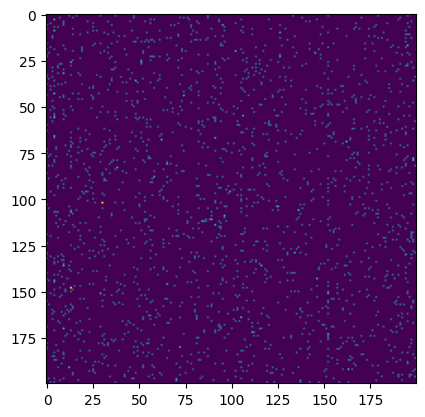

In [18]:
plt.imshow(confusion_matrix/confusion_matrix.max())